<img src='https://s3.amazonaws.com/weclouddata/images/logos/bell.png' width='15%'>

<h1 align='center'> Python Pipeline for Predictive Modelling (Demo) </h1>
<center align="left"> Prepared by: Bohang Zhang </center>

## Import Packages

In [36]:
%matplotlib inline

# bases
import pandas as pd
import numpy as np

# nodes
import var_binning as vb
import var_clustering as vc
import var_selection as vs
import utility as utl
import models as mdl
import impute as imp
import replacement as rep
import visualization as vis
from sklearn.model_selection import train_test_split

# helper functions
from scipy.stats import rankdata
from sklearn.externals import joblib
from keras.models import load_model
from numpy.random import seed
from tensorflow import set_random_seed
from scikitplot.metrics import plot_confusion_matrix, plot_cumulative_gain
import time

In [2]:
help(mdl.NN_keras_sequential_model)

Help on function NN_keras_sequential_model in module models:

NN_keras_sequential_model(input_dim=None, show_metrics=[<function binary_accuracy at 0x0000023C7EEBC488>], layer_units=[3, 2], activation_fns=['relu', 'relu'], w_initializer='glorot_normal', b_initializer='zeros', regularization='dropout', _lambda_=0.01, _dropout_rate_=0.5, loss_fn='binary_crossentropy', n_classes=2, output_fn='sigmoid', optimizer='adam', _learning_rate_=0.01, batch_norm=True, **kwargs)
    Create a Keras Sequential Model. Can be called by NN_keras_sequential_validation() and NN_keras_sequential_CV().
    
    Parameters
    --------------------------------
    input_dim : int
        the number of columns for the input dataset. **mandatory** to be passed as an argument.
    show_metrics : List of str / List of keras.metrics
        metrics showed during the fitting process.
    layer_units : List of int
        hidden layers and hidden units. length should be same with the length of activation_fns.
    acti

## Seed and Open HDF5 Store

When we need to pickle all the states of python variables (avoid re-running), open HDF5 to quickly store every version of DataFrames.

In [3]:
seed(12345)
set_random_seed(12345)
# h5store = pd.HDFStore("b_cond_web_melc_data.h5")

# Training Set Preprocessing

## Dataset

Before cleaning the raw data:
- read sas dataset (or other format) as **df**
- extract variable reference table from Teradata (dl_brs_factory.shr_r_factory_variable) as **df_variable_ref**
- set role for each variable, and store as **df_variable**:
    - Level: interval, ordinal, nominal, etc.
    - Role: input, rejected, target, etc.

In [5]:
df = pd.read_sas("reb_b_cond_web_melc.sas7bdat", encoding="latin-1")
df_variable_ref = utl.extract_tbl("BOHANG_ZHANG", "...")
df_variable = utl.set_role(df, df_variable_ref, "b_cond_web_melc")

In [6]:
df_variable_ref.head()

,VARIABLE_NM,ALIAS_NM,ROLE_NM,LEVEL_NM,DESCRIPTION,CATG_NM,SOURCE_DB,SOURCE_TBL,COLUMN_SEQ_NO,AGGREGATION_TYPE,TABLE_JOIN_COLMN_NM,BASE_JOIN_COLMN_NM,BASE_PERIOD_JOIN_COLMN_NM,TABLE_PERIOD_JOIN_COLMN_NM,COALESCE_VAL,BASE_TABLE_NM,VIEW_NM,VIEW_DESC,VIEW_ALIAS_NM
0,v_cond_hug_rtl_melc_score_Ind,v_cond_hug_rtl_melc_score_Ind,REJECTED,BINARY,Score/Target Indicators,Score/Target,dl_brs_factory,BM_S_FACTORY_TGT_SUB_UPSELL,996,WEEKLY,SRC_SUB_NO,SRC_SUB_NO,PERIOD_DT,PERIOD_DT,0,BI_MODEL.BM_F_FACTORY_SUB_BASE,BI_MODEL.VI_BM_FACTORY_TGT,BM FACTORY TARGET,BI_MODEL.VI_BM_FACTORY_ALIAS
1,BRS_TENURE_HH_BAN_MAX_MTH_BIN,BRS_TEN_MAX_B,INPUT,NOMINAL,BRS TENURE: MAXIMUM TENURE IN MONTHS FOR ALL L...,BRS TENURE,dl_brs_factory,BM_F_FACTORY_BAN_BRS,267,WEEKLY,SRC_BAN,SRC_BAN,PERIOD_DT,PERIOD_DT,None,BI_MODEL.BM_F_FACTORY_SUB_BASE,BI_MODEL.VI_BM_FACTORY_HIST,BM FACTORY HISTORY,BI_MODEL.VI_BM_FACTORY_ALIAS
2,BAN_AVG_ADDR_TENURE_DAY_CNT,avgt_addr_ten,INPUT,INTERVAL,The average tenure a ban spends at a given add...,STATUS,dl_brs_factory,BM_F_FACTORY_SUB_BASE,98,WEEKLY,SRC_SUB_NO,SRC_SUB_NO,PERIOD_DT,PERIOD_DT,None,BI_MODEL.BM_F_FACTORY_SUB_BASE,BI_MODEL.VI_BM_FACTORY_HIST,BM FACTORY HISTORY,BI_MODEL.VI_BM_FACTORY_ALIAS
3,BAN_OTHER_PHONES_NUM,ban_other_ph,INPUT,INTERVAL,Number of phones currently on the BAN which ar...,Current Status,dl_brs_factory,BM_S_FACTORY_BAN_HW,106,WEEKLY,SRC_BAN,SRC_BAN,PERIOD_DT,PERIOD_DT,None,BI_MODEL.BM_F_FACTORY_SUB_BASE,BI_MODEL.VI_BM_FACTORY_HIST,BM FACTORY HISTORY,BI_MODEL.VI_BM_FACTORY_ALIAS
4,IVR_CALL_3M_CNT,IVR_3M,INPUT,INTERVAL,IVR calls in last 90 days,INTERACTION,dl_brs_factory,BM_F_FACTORY_CUST_EXPRNCE,492,WEEKLY,sub_no,SRC_SUB_NO,period_dt,period_dt,None,BI_MODEL.BM_F_FACTORY_SUB_BASE,BI_MODEL.VI_BM_FACTORY_HIST,BM FACTORY HISTORY,BI_MODEL.VI_BM_FACTORY_ALIAS


In [7]:
df_variable.head()

,Role,Level
period_dt,REJECTED,INTERVAL
SRC_SUB_NO,ID,NOMINAL
CNTRCT_STS,INPUT,NOMINAL
TOP_TWR_PCT,INPUT,INTERVAL
OTH_FEAT_RC_RT,INPUT,INTERVAL


## Data Partition

In [8]:
train, test = train_test_split(df, test_size=0.7, random_state=12345)
test, test2 = train_test_split(test, test_size=5.5/7, random_state=12345)

## Variable Selection

Reject some variables, modify the **df_variable**:
- for **nominal variables**, reject those which contain more than 200 levels.
- for **all the variables**, reject those which contain more than 99% of missing values.

In [9]:
vs.class_level_filter(train, df_variable)
vs.missing_percent_filter(train, df_variable)

## Imputation

Impute for missing values based on the specified method or default method:
- if set **inplace=True**, create new variables "IMP_varname" and modify **train** and **df_variable**
- store the training set information as **impute_train_for_test**, which will be used for test set imputation

In [10]:
train, df_variable, impute_train_for_test = imp.impute_train(train, df_variable, inplace=True)

Impute for INTERVAL variables
reach: TOP_TWR_PCT
reach: OTH_FEAT_RC_RT
reach: DIST_CTN
reach: EVT_CHRG_1v3
reach: tablet_cnt
reach: INC_VC_PCT
reach: LD_INC_VC_PCT
reach: DAT_USE_CHRG3
reach: WKNGT_TXT_PCT
reach: PP_VOL_CHRN
reach: INC_RT_VC_MIN
reach: avg_sub_ten
reach: PENALTY_ADJ
reach: port_in_cnt
reach: RM_RT_DATA
reach: DROP_DC_PCT
reach: DROP_VC_PCT
reach: CMA_VOL_CHRN
reach: TOT_VC_MIN
reach: MOU_USE_CHRG3
reach: TOT_HM_VC_MIN
reach: CHRG_1v3
reach: SPA_DELTA
reach: TOT_VC_CNT
reach: AR_BAL
reach: HM_RT_DATA
reach: TOT_ROAM3
reach: TOT_CHRG
reach: HM_FREE_DATA
reach: TOT_USG_MB
reach: INC_TXT_PCT
reach: PP_CHNG_NUM
reach: RM_FREE_DATA
reach: MISC_CHRG
reach: TOT_MRC_AMT
reach: SUB_COAM_CNT
reach: RM_TXT_PCT
reach: CMA_INVOL_CHRN
reach: EVT_USE_CHRG3
reach: SUB_TEN_DAY
reach: SUBS_IN_BAN
reach: COM_ORG_MTH
reach: PP_DIFF_AMT
reach: WKND_TXT_PCT
reach: TOT_OVERAGE
reach: AVG_CTN_TEN
reach: NOTIF_CNT
reach: SUB_LLC_CNT
reach: TOT_ROAM
reach: SPA_SAVE_PCT
reach: CNTRCT_DAY
reach: C

In [11]:
train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 708713 to 741858
Data columns (total 326 columns):
period_dt                     300000 non-null datetime64[ns]
SRC_SUB_NO                    300000 non-null object
CNTRCT_STS                    300000 non-null object
TOP_TWR_PCT                   285762 non-null float64
OTH_FEAT_RC_RT                218312 non-null float64
DIST_CTN                      299164 non-null float64
EVT_CHRG_1v3                  4016 non-null float64
tablet_cnt                    300000 non-null float64
INC_VC_PCT                    292325 non-null float64
SOC_CHG_DESC                  18640 non-null object
PPD_TOPUP_1v3                 0 non-null float64
ACTVT_CHANNEL                 238910 non-null object
LD_INC_VC_PCT                 292325 non-null float64
DAT_USE_CHRG3                 134416 non-null float64
WKNGT_TXT_PCT                 294438 non-null float64
TOLL_CHRG_3                   0 non-null float64
PP_VOL_CHRN                  

## Tree Variable Selection

Random Forest or Decision Tree for variable selection based on the feature importance values:
- modify the **df_variable** to reject some variables, if set **inplace=True**
- store the fitting rf model or tree model as **var_selection_model**
- return a list of variables as **var_selection_rej_vars** that are rejected in the selection process

In [12]:
rf_var_selection_model, rf_var_selection_rej_vars = \
    vs.rf_var_selection(train, df_variable, feat_importance=0.001, feat_imp_method="value", inplace=True)

Data Wrangling
LabelEncoding
Running Random Forest


## Variable Clustering

Cluster similar variables and choose the best one for each cluster:
- modify the **df_variable** to reject some variables, if set **inplace=True**
- return a dict to store information for each cluster as **var_clus_clusters**
- return a list of variables as **var_clus_best_vars** which are the best variables in each cluster

In [13]:
var_clus_clusters, var_clus_best_vars = vc.variable_clustering(train, df_variable, inplace=True)

Data Wrangling
Feature Normalization
Create Clusters
1 clusters in total, splitting cluster1 in current loop
2 clusters in total, splitting cluster2 in current loop
3 clusters in total, splitting cluster3 in current loop
4 clusters in total, splitting cluster2 in current loop
5 clusters in total, splitting cluster1 in current loop
6 clusters in total, splitting cluster6 in current loop
7 clusters in total, splitting cluster2 in current loop
8 clusters in total, splitting cluster8 in current loop
9 clusters in total, splitting cluster3 in current loop
10 clusters in total, splitting cluster5 in current loop
11 clusters in total, splitting cluster1 in current loop
12 clusters in total, splitting cluster1 in current loop
13 clusters in total, splitting cluster6 in current loop
14 clusters in total, splitting cluster14 in current loop
15 clusters in total, splitting cluster11 in current loop
16 clusters in total, splitting cluster1 in current loop
17 clusters in total, splitting cluster2 i

## Variable Binning

For some nominal variables, group rare levels into _OTHER_:
- if set **inplace=True**, create new variables "BIN_varname" and modify the **train** and **df_variable**
- store the training information as **group_lvl_result**, which will be used for test set variable binning

In [14]:
train, df_variable, group_lvl_result = vb.group_rare_level_train(train, df_variable, inplace=True)

reach: IMP_CNTRCT_STS
reach: IMP_ACTVT_CHANNEL
reach: IMP_RC_RT_RANGE
reach: IMP_SPA_CHG_GRP
reach: IMP_MOST_EXP_LC
reach: IMP_AGPT
reach: IMP_SPA_CHG_SUB
reach: IMP_OLD_SUB_LC
reach: IMP_NW_SUB_TYPE_CD
reach: IMP_EMAIL_CAT
reach: IMP_NEW_SUB_LC


## Replacement

Record all the levels appeared in the training set for nominal variables:
- if set **inplace=True**, create new variables "REP_varname" and modify the **train** and **df_variable**
- stored information as **rep_train_for_test**

In [15]:
train, df_variable, rep_train_for_test = rep.replacement_train(train, df_variable, inplace=True)

# Test Set Preprocessing

For **imputation, variable binning, and replacement**, used information stored from training set preprocessing.

In [17]:
imp.impute_test(test, impute_train_for_test)
vb.group_rare_level_test(test, group_lvl_result)
rep.replacement_test(test, rep_train_for_test)

Impute for INTERVAL variables
reach: TOP_TWR_PCT
reach: OTH_FEAT_RC_RT
reach: DIST_CTN
reach: EVT_CHRG_1v3
reach: tablet_cnt
reach: INC_VC_PCT
reach: LD_INC_VC_PCT
reach: DAT_USE_CHRG3
reach: WKNGT_TXT_PCT
reach: PP_VOL_CHRN
reach: INC_RT_VC_MIN
reach: avg_sub_ten
reach: PENALTY_ADJ
reach: port_in_cnt
reach: RM_RT_DATA
reach: DROP_DC_PCT
reach: DROP_VC_PCT
reach: CMA_VOL_CHRN
reach: TOT_VC_MIN
reach: MOU_USE_CHRG3
reach: TOT_HM_VC_MIN
reach: CHRG_1v3
reach: SPA_DELTA
reach: TOT_VC_CNT
reach: AR_BAL
reach: HM_RT_DATA
reach: TOT_ROAM3
reach: TOT_CHRG
reach: HM_FREE_DATA
reach: TOT_USG_MB
reach: INC_TXT_PCT
reach: PP_CHNG_NUM
reach: RM_FREE_DATA
reach: MISC_CHRG
reach: TOT_MRC_AMT
reach: SUB_COAM_CNT
reach: RM_TXT_PCT
reach: CMA_INVOL_CHRN
reach: EVT_USE_CHRG3
reach: SUB_TEN_DAY
reach: SUBS_IN_BAN
reach: COM_ORG_MTH
reach: PP_DIFF_AMT
reach: WKND_TXT_PCT
reach: TOT_OVERAGE
reach: AVG_CTN_TEN
reach: NOTIF_CNT
reach: SUB_LLC_CNT
reach: TOT_ROAM
reach: SPA_SAVE_PCT
reach: CNTRCT_DAY
reach: C

# Models

## Final Preprocessing for LR

Get the datasets ready for the model fitting:
- for some binary variables, replace strings with 0 or 1 ("N" to 0 and "Y" to 1)
- for some nominal variables, get dummy variables
- standardize interval variables

In [18]:
train_input, train_target, test_input, test_target, scaler_input, scaler_tgt = \
    utl.final_preprocessing(train, test, df_variable, input_std=None)

change binary variables to integer values
one-hot nominal variables to dummy variables


## Logistic Regression

Use single validation to get the best regularization parameter to avoid overfitting.

In [20]:
model_logit, model_logit_report, model_logit_test_pred, model_logit_test_pred_prob \
    = mdl.Logistic_Regression_validation_model(train_input, train_target, test_input, test_target, threshold_search=[0.9, 1, 100], 
                                               model_search=[-3, 2, 10], model_metric="cumulative lift", depth=0.15)

search for the best regularization parameter (c)
reach: c = 0.001
reach: c = 0.003593813663804626
reach: c = 0.01291549665014884
reach: c = 0.046415888336127795
reach: c = 0.1668100537200059
reach: c = 0.5994842503189409
reach: c = 2.1544346900318843
reach: c = 7.742636826811277
reach: c = 27.825594022071257
reach: c = 100.0
search for the best split threshold to label the prediction
obtain the prediction results and evaluation results


## Metric Scores for LR

In [21]:
print(model_logit_report["classification_report"] + "\n")
print("lift : {0}".format(mdl.lift(test_target, model_logit_test_pred_prob, depth=0.1)))
print("cumulative lift with 0.2 depth : {0}\n".format(mdl.cum_lift(test_target, model_logit_test_pred_prob, depth=0.2)))

             precision    recall  f1-score   support

        0.0       1.00      0.99      0.99    149482
        1.0       0.02      0.07      0.04       518

avg / total       0.99      0.99      0.99    150000


lift : 3.571428571428571
cumulative lift with 0.2 depth : 0.5482625482625483



## Graphs and Visualizations for LR

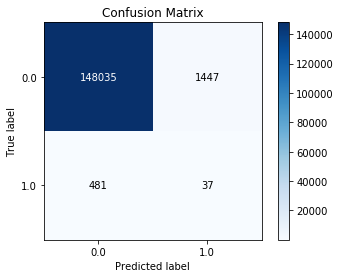

In [22]:
plot_confusion_matrix(test_target, model_logit_test_pred)

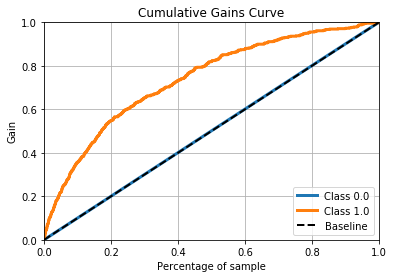

In [23]:
plot_cumulative_gain(test_target, model_logit_test_pred_prob)

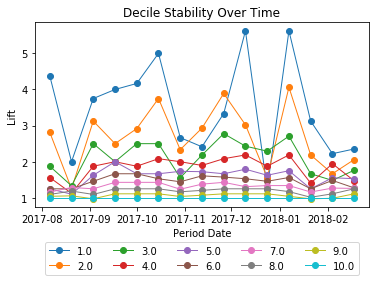

In [24]:
vis.plot_decile_stability_over_time(test_target, model_logit_test_pred_prob, test.period_dt)

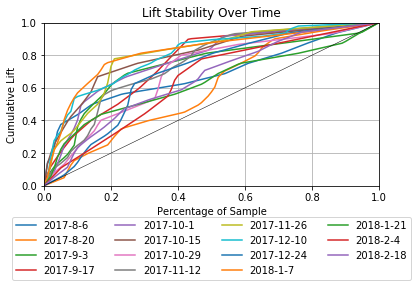

In [25]:
vis.plot_lift_stability_over_time(test_target, model_logit_test_pred_prob, test.period_dt)

## Final Preprocessing for NN

In [26]:
train_input, train_target, test_input, test_target, scaler_input_NN_keras_seq, scaler_tgt_NN_keras_seq = utl.final_preprocessing(
    train, test, df_variable)

change binary variables to integer values
one-hot nominal variables to dummy variables


## Neural Nets with Keras Sequential

More customized:
- any hyperparameters can be chosed to tune
- different metrics can be used as decision criteria
- advanced techniques can be used (batch normalization, dropout, other optimizers, user-defined activation fns, etc.)

In [27]:
models_nn_keras_seq_v, models_nn_keras_seq_v_param, models_nn_keras_seq_v_scr = \
    mdl.NN_keras_sequential_validation(train_input, train_target, test_input, test_target,
                                       model_metric="cumulative lift", n_models=20,
                                       tuneDict={"_learning_rate_": np.round(np.logspace(-4, -2, 50), 6),
                                                 "_dropout_rate_": [0.3, 0.4, 0.5, 0.6], "epochs": [10,20,25,30,40,50]},
                                       depth=0.15)

regularization: dropout
dropout rate: 0.4
batch normalization: True
learning rate: 0.000146
Epoch 1/10
300000/300000 [==============================] - 7s 23us/step - loss: 0.7481 - binary_accuracy: 0.5824
Epoch 2/10
300000/300000 [==============================] - 6s 20us/step - loss: 0.6281 - binary_accuracy: 0.9299
Epoch 3/10
300000/300000 [==============================] - 5s 18us/step - loss: 0.5465 - binary_accuracy: 0.9716
Epoch 4/10
300000/300000 [==============================] - 5s 18us/step - loss: 0.4772 - binary_accuracy: 0.9790
Epoch 5/10
300000/300000 [==============================] - 5s 18us/step - loss: 0.4132 - binary_accuracy: 0.9817
Epoch 6/10
300000/300000 [==============================] - 5s 18us/step - loss: 0.3564 - binary_accuracy: 0.9825
Epoch 7/10
300000/300000 [==============================] - 5s 18us/step - loss: 0.3089 - binary_accuracy: 0.9907
Epoch 8/10
300000/300000 [==============================] - 6s 18us/step - loss: 0.2699 - binary_accuracy: 0.9

300000/300000 [==============================] - 5s 18us/step - loss: 0.0236 - binary_accuracy: 0.9963
Epoch 30/50
300000/300000 [==============================] - 6s 18us/step - loss: 0.0236 - binary_accuracy: 0.9963
Epoch 31/50
300000/300000 [==============================] - 5s 18us/step - loss: 0.0235 - binary_accuracy: 0.9963
Epoch 32/50
300000/300000 [==============================] - 5s 18us/step - loss: 0.0236 - binary_accuracy: 0.9963
Epoch 33/50
300000/300000 [==============================] - 5s 18us/step - loss: 0.0236 - binary_accuracy: 0.9963
Epoch 34/50
300000/300000 [==============================] - 5s 18us/step - loss: 0.0236 - binary_accuracy: 0.9963
Epoch 35/50
300000/300000 [==============================] - 5s 18us/step - loss: 0.0236 - binary_accuracy: 0.9963
Epoch 36/50
300000/300000 [==============================] - 6s 18us/step - loss: 0.0235 - binary_accuracy: 0.9963
Epoch 37/50
300000/300000 [==============================] - 5s 18us/step - loss: 0.0235 - b

300000/300000 [==============================] - 6s 19us/step - loss: 0.0761 - binary_accuracy: 0.9963
Epoch 24/50
300000/300000 [==============================] - 6s 19us/step - loss: 0.0695 - binary_accuracy: 0.9963
Epoch 25/50
300000/300000 [==============================] - 6s 19us/step - loss: 0.0636 - binary_accuracy: 0.9963
Epoch 26/50
300000/300000 [==============================] - 6s 20us/step - loss: 0.0584 - binary_accuracy: 0.9963
Epoch 27/50
300000/300000 [==============================] - 6s 20us/step - loss: 0.0538 - binary_accuracy: 0.9963
Epoch 28/50
300000/300000 [==============================] - 6s 21us/step - loss: 0.0497 - binary_accuracy: 0.9963
Epoch 29/50
300000/300000 [==============================] - 6s 20us/step - loss: 0.0461 - binary_accuracy: 0.9963
Epoch 30/50
300000/300000 [==============================] - 6s 20us/step - loss: 0.0429 - binary_accuracy: 0.9963
Epoch 31/50
300000/300000 [==============================] - 6s 21us/step - loss: 0.0402 - b

300000/300000 [==============================] - 7s 22us/step - loss: 0.0311 - binary_accuracy: 0.9963
Epoch 23/50
300000/300000 [==============================] - 6s 21us/step - loss: 0.0292 - binary_accuracy: 0.9963
Epoch 24/50
300000/300000 [==============================] - 6s 20us/step - loss: 0.0277 - binary_accuracy: 0.9963
Epoch 25/50
300000/300000 [==============================] - 6s 20us/step - loss: 0.0267 - binary_accuracy: 0.9963
Epoch 26/50
300000/300000 [==============================] - 6s 21us/step - loss: 0.0259 - binary_accuracy: 0.9963: 0s - loss: 0.0259 - binary_accuracy:
Epoch 27/50
300000/300000 [==============================] - 6s 20us/step - loss: 0.0253 - binary_accuracy: 0.9963
Epoch 28/50
300000/300000 [==============================] - 6s 21us/step - loss: 0.0249 - binary_accuracy: 0.9963
Epoch 29/50
300000/300000 [==============================] - 6s 20us/step - loss: 0.0247 - binary_accuracy: 0.9963
Epoch 30/50
300000/300000 [===========================

300000/300000 [==============================] - 6s 21us/step - loss: 0.0243 - binary_accuracy: 0.9963
Epoch 12/25
300000/300000 [==============================] - 6s 21us/step - loss: 0.0243 - binary_accuracy: 0.9963
Epoch 13/25
300000/300000 [==============================] - 6s 21us/step - loss: 0.0242 - binary_accuracy: 0.9963
Epoch 14/25
300000/300000 [==============================] - 6s 21us/step - loss: 0.0242 - binary_accuracy: 0.9963
Epoch 15/25
300000/300000 [==============================] - 6s 21us/step - loss: 0.0241 - binary_accuracy: 0.9963
Epoch 16/25
300000/300000 [==============================] - 6s 21us/step - loss: 0.0241 - binary_accuracy: 0.9963
Epoch 17/25
300000/300000 [==============================] - 6s 21us/step - loss: 0.0241 - binary_accuracy: 0.9963
Epoch 18/25
300000/300000 [==============================] - 6s 21us/step - loss: 0.0240 - binary_accuracy: 0.9963
Epoch 19/25
300000/300000 [==============================] - 6s 21us/step - loss: 0.0241 - b

300000/300000 [==============================] - 6s 21us/step - loss: 0.0286 - binary_accuracy: 0.9963
Epoch 36/40
300000/300000 [==============================] - 6s 21us/step - loss: 0.0277 - binary_accuracy: 0.9963
Epoch 37/40
300000/300000 [==============================] - 6s 22us/step - loss: 0.0269 - binary_accuracy: 0.9963
Epoch 38/40
300000/300000 [==============================] - 6s 21us/step - loss: 0.0263 - binary_accuracy: 0.9963
Epoch 39/40
300000/300000 [==============================] - 6s 21us/step - loss: 0.0258 - binary_accuracy: 0.9963
Epoch 40/40
300000/300000 [==============================] - 6s 21us/step - loss: 0.0254 - binary_accuracy: 0.9963
regularization: dropout
dropout rate: 0.3
batch normalization: True
learning rate: 0.000146
Epoch 1/30
300000/300000 [==============================] - 8s 27us/step - loss: 0.7315 - binary_accuracy: 0.4233
Epoch 2/30
300000/300000 [==============================] - 6s 21us/step - loss: 0.6215 - binary_accuracy: 0.7845
Ep

300000/300000 [==============================] - 6s 21us/step - loss: 0.0242 - binary_accuracy: 0.9963
Epoch 35/40
300000/300000 [==============================] - 6s 21us/step - loss: 0.0242 - binary_accuracy: 0.9963
Epoch 36/40
300000/300000 [==============================] - 6s 21us/step - loss: 0.0242 - binary_accuracy: 0.9963
Epoch 37/40
300000/300000 [==============================] - 6s 21us/step - loss: 0.0242 - binary_accuracy: 0.9963
Epoch 38/40
300000/300000 [==============================] - 6s 21us/step - loss: 0.0242 - binary_accuracy: 0.9963
Epoch 39/40
300000/300000 [==============================] - 7s 22us/step - loss: 0.0242 - binary_accuracy: 0.9963
Epoch 40/40
300000/300000 [==============================] - 6s 21us/step - loss: 0.0242 - binary_accuracy: 0.9963
regularization: dropout
dropout rate: 0.6
batch normalization: True
learning rate: 0.000256
Epoch 1/25
300000/300000 [==============================] - 9s 29us/step - loss: 0.6738 - binary_accuracy: 0.5727
E

300000/300000 [==============================] - 6s 22us/step - loss: 0.0240 - binary_accuracy: 0.9963
Epoch 39/40
300000/300000 [==============================] - 6s 22us/step - loss: 0.0240 - binary_accuracy: 0.9963
Epoch 40/40
300000/300000 [==============================] - 7s 22us/step - loss: 0.0240 - binary_accuracy: 0.9963
regularization: dropout
dropout rate: 0.3
batch normalization: True
learning rate: 0.004292
Epoch 1/50
300000/300000 [==============================] - 9s 29us/step - loss: 0.2286 - binary_accuracy: 0.9636
Epoch 2/50
300000/300000 [==============================] - 7s 22us/step - loss: 0.0470 - binary_accuracy: 0.9963
Epoch 3/50
300000/300000 [==============================] - 7s 22us/step - loss: 0.0295 - binary_accuracy: 0.9963
Epoch 4/50
300000/300000 [==============================] - 6s 21us/step - loss: 0.0255 - binary_accuracy: 0.9963
Epoch 5/50
300000/300000 [==============================] - 7s 22us/step - loss: 0.0245 - binary_accuracy: 0.9963
Epoch

300000/300000 [==============================] - 7s 23us/step - loss: 0.0795 - binary_accuracy: 0.9963
Epoch 7/10
300000/300000 [==============================] - 7s 24us/step - loss: 0.0589 - binary_accuracy: 0.9963
Epoch 8/10
300000/300000 [==============================] - 7s 23us/step - loss: 0.0454 - binary_accuracy: 0.9963
Epoch 9/10
300000/300000 [==============================] - 7s 23us/step - loss: 0.0367 - binary_accuracy: 0.9963
Epoch 10/10
300000/300000 [==============================] - 7s 23us/step - loss: 0.0312 - binary_accuracy: 0.9963
regularization: dropout
dropout rate: 0.5
batch normalization: True
learning rate: 0.002442
Epoch 1/50
300000/300000 [==============================] - 10s 32us/step - loss: 0.3240 - binary_accuracy: 0.9753
Epoch 2/50
300000/300000 [==============================] - 7s 23us/step - loss: 0.0843 - binary_accuracy: 0.9963
Epoch 3/50
300000/300000 [==============================] - 7s 23us/step - loss: 0.0433 - binary_accuracy: 0.9963
Epoch

300000/300000 [==============================] - 7s 24us/step - loss: 0.0286 - binary_accuracy: 0.9963
Epoch 16/40
300000/300000 [==============================] - 7s 24us/step - loss: 0.0268 - binary_accuracy: 0.9963
Epoch 17/40
300000/300000 [==============================] - 7s 23us/step - loss: 0.0256 - binary_accuracy: 0.9963
Epoch 18/40
300000/300000 [==============================] - 7s 23us/step - loss: 0.0249 - binary_accuracy: 0.9963
Epoch 19/40
300000/300000 [==============================] - 7s 23us/step - loss: 0.0245 - binary_accuracy: 0.9963
Epoch 20/40
300000/300000 [==============================] - 7s 23us/step - loss: 0.0243 - binary_accuracy: 0.9963
Epoch 21/40
300000/300000 [==============================] - 7s 24us/step - loss: 0.0242 - binary_accuracy: 0.9963
Epoch 22/40
300000/300000 [==============================] - 7s 23us/step - loss: 0.0241 - binary_accuracy: 0.9963
Epoch 23/40
300000/300000 [==============================] - 7s 24us/step - loss: 0.0241 - b

## Metric Scores for NN

In [28]:
final_models = [i for (i, v) in zip(models_nn_keras_seq_v, rankdata(models_nn_keras_seq_v_scr, method="min") >= 15) if v]
for i in range(len(final_models)):
    model_i = final_models[i]
    predictions = model_i.predict(test_input)
    model_nn_test_pred = np.append((1 - predictions[:, 0]).reshape((len(test_input), 1)), predictions, axis=1)
    print("model {} lift : {}".format(i+1, mdl.lift(test_target, model_nn_test_pred, depth=0.1)))
    print("model {} cumulative lift with 0.2 depth : {}\n".format(i+1, mdl.cum_lift(test_target, model_nn_test_pred, depth=0.2)))

model 1 lift : 3.3397683397683395
model 1 cumulative lift with 0.2 depth : 0.5212355212355212

model 2 lift : 3.5328185328185326
model 2 cumulative lift with 0.2 depth : 0.5482625482625483

model 3 lift : 3.3976833976833976
model 3 cumulative lift with 0.2 depth : 0.528957528957529

model 4 lift : 3.378378378378378
model 4 cumulative lift with 0.2 depth : 0.5019305019305019

model 5 lift : 3.59073359073359
model 5 cumulative lift with 0.2 depth : 0.5366795366795367

model 6 lift : 3.378378378378378
model 6 cumulative lift with 0.2 depth : 0.527027027027027



## Graphs and Visualizations for NN

Randomly choose two models.
- get the **predictions**
- change the format of the returned arrays so that they can be passed into graph functions

In [29]:
model_1 = final_models[1]
predictions_test = model_1.predict(test_input)
predictions_train = model_1.predict(train_input)

model_1_test_pred = np.append((1 - predictions_test[:, 0]).reshape((len(test_input), 1)), predictions_test, axis=1)
model_1_train_pred = np.append((1 - predictions_train[:, 0]).reshape((len(train_input), 1)), predictions_train, axis=1)

Neural Nets Model 1 Graphs for Training Set


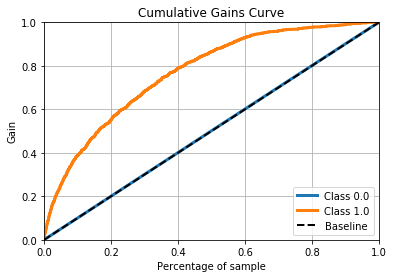

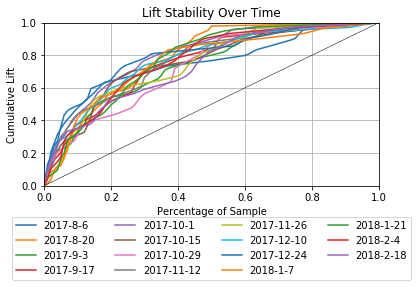

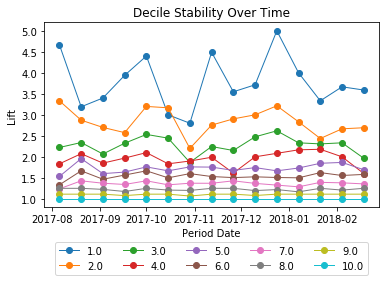

In [30]:
print("Neural Nets Model 1 Graphs for Training Set")
plot_cumulative_gain(train_target, model_1_train_pred)
vis.plot_lift_stability_over_time(train_target, model_1_train_pred, train.period_dt)
vis.plot_decile_stability_over_time(train_target, model_1_train_pred, train.period_dt)

Neural Nets Model 1 Graphs for Test Set


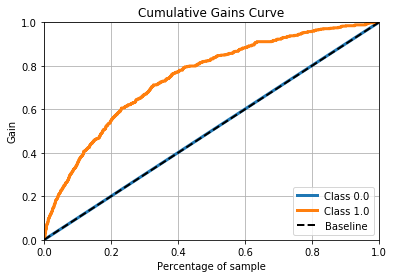

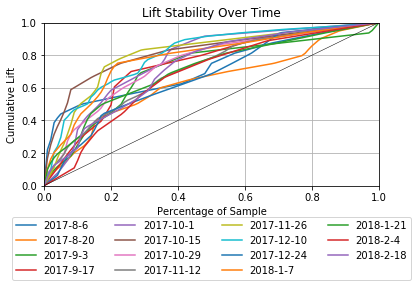

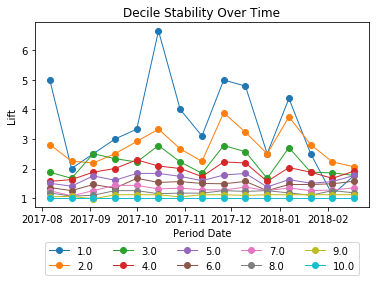

In [31]:
print("Neural Nets Model 1 Graphs for Test Set")
plot_cumulative_gain(test_target, model_1_test_pred)
vis.plot_lift_stability_over_time(test_target, model_1_test_pred, test.period_dt)
vis.plot_decile_stability_over_time(test_target, model_1_test_pred, test.period_dt)

In [37]:
model_2 = final_models[4]
predictions_test = model_2.predict(test_input)
predictions_train = model_2.predict(train_input)

model_2_test_pred = np.append((1 - predictions_test[:, 0]).reshape((len(test_input), 1)), predictions_test, axis=1)
model_2_train_pred = np.append((1 - predictions_train[:, 0]).reshape((len(train_input), 1)), predictions_train, axis=1)

Neural Nets Model 2 Graphs for Training Set


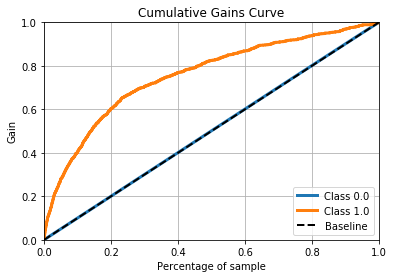

In [40]:
print("Neural Nets Model 2 Graphs for Training Set")
plot_cumulative_gain(train_target, model_2_train_pred)
vis.plot_lift_stability_over_time(train_target, model_2_train_pred, train.period_dt, plotly=True)
vis.plot_decile_stability_over_time(train_target, model_2_train_pred, train.period_dt, plotly=True)

Neural Nets Model 2 Graphs for Test Set


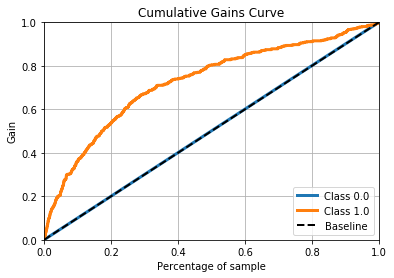

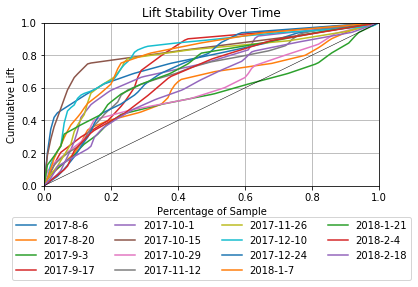

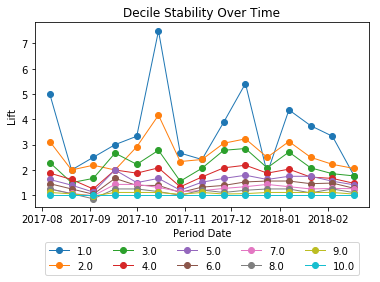

In [41]:
print("Neural Nets Model 2 Graphs for Test Set")
plot_cumulative_gain(test_target, model_2_test_pred)
vis.plot_lift_stability_over_time(test_target, model_2_test_pred, test.period_dt)
vis.plot_decile_stability_over_time(test_target, model_2_test_pred, test.period_dt)